# OverlandFlow Flux Validation Visualization

Visualize differences between ParFlow qx_overland/qy_overland outputs and independently calculated fluxes for OverlandFlow method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from parflow.tools.io import read_pfb
from parflow.tools.hydrology import calculate_overland_fluxes

%matplotlib inline

## Load ParFlow Outputs

In [2]:
# Configuration
output_dir = "test_output/FluxValidation_OverlandFlow"
run_name = "FluxValidation_OverlandFlow"
timestep = 5
dx = 10.0
dy = 10.0
dt = 0.05
flow_method = 'OverlandFlow'

timestep_str = str(timestep).rjust(5, "0")

# File paths
press_file = f"{output_dir}/{run_name}.out.press.{timestep_str}.pfb"
qx_file = f"{output_dir}/{run_name}.out.qx_overland.{timestep_str}.pfb"
qy_file = f"{output_dir}/{run_name}.out.qy_overland.{timestep_str}.pfb"
slope_x_file = f"{output_dir}/{run_name}.out.slope_x.pfb"
slope_y_file = f"{output_dir}/{run_name}.out.slope_y.pfb"
mannings_file = f"{output_dir}/{run_name}.out.mannings.pfb"
mask_file = f"{output_dir}/{run_name}.out.mask.pfb"

print("Loading ParFlow outputs...")
pressure = read_pfb(press_file)
qx_pf = read_pfb(qx_file)
qy_pf = read_pfb(qy_file)
slope_x = read_pfb(slope_x_file)
slope_y = read_pfb(slope_y_file)
mannings = read_pfb(mannings_file)
mask = read_pfb(mask_file)

print(f"Pressure shape: {pressure.shape}")
print(f"qx_overland shape: {qx_pf.shape}")
print(f"qy_overland shape: {qy_pf.shape}")
print(f"Slope X shape: {slope_x.shape}")
print(f"Manning's shape: {mannings.shape}")
print(f"Mask shape: {mask.shape}")

Loading ParFlow outputs...
Pressure shape: (1, 5, 5)
qx_overland shape: (1, 5, 5)
qy_overland shape: (1, 5, 5)
Slope X shape: (1, 5, 5)
Manning's shape: (1, 5, 5)
Mask shape: (1, 5, 5)


## Extract 2D Arrays

In [3]:
# Extract ParFlow outputs (multiply by dx/dy to convert to volumetric flux)
if len(qx_pf.shape) == 3:
    qx_pf_2d = qx_pf[0, :, :] * dy
    qy_pf_2d = qy_pf[0, :, :] * dx
else:
    qx_pf_2d = qx_pf * dy
    qy_pf_2d = qy_pf * dx

# Extract slopes and Manning's
if len(slope_x.shape) == 3:
    slope_x_2d = slope_x[0, :, :]
    slope_y_2d = slope_y[0, :, :]
    mannings_2d = mannings[0, :, :]
else:
    slope_x_2d = slope_x
    slope_y_2d = slope_y
    mannings_2d = mannings

print(f"ParFlow qx shape: {qx_pf_2d.shape}")
print(f"ParFlow qy shape: {qy_pf_2d.shape}")
print(f"\nParFlow qx range: [{qx_pf_2d.min():.6e}, {qx_pf_2d.max():.6e}]")
print(f"ParFlow qy range: [{qy_pf_2d.min():.6e}, {qy_pf_2d.max():.6e}]")

ParFlow qx shape: (5, 5)
ParFlow qy shape: (5, 5)

ParFlow qx range: [-5.367896e-02, 5.367896e-02]
ParFlow qy range: [-9.696655e-01, -6.454411e-03]


## Calculate Independent Fluxes

In [4]:
print("Calculating fluxes using ParFlow hydrology tools...")
qx_calc, qy_calc = calculate_overland_fluxes(
    pressure,
    slope_x_2d,
    slope_y_2d,
    mannings_2d,
    dx,
    dy,
    flow_method=flow_method,
    epsilon=1e-5,
    mask=mask
)

print(f"Raw calculated qx shape: {qx_calc.shape}")
print(f"Raw calculated qy shape: {qy_calc.shape}")

# Subset for OverlandFlow (cell-centered, remove last column/row)
if len(qx_calc.shape) == 3:
    qx_calc_2d = qx_calc[0, :, :-1]
    qy_calc_2d = qy_calc[0, :-1, :]
else:
    qx_calc_2d = qx_calc[:, :-1]
    qy_calc_2d = qy_calc[:-1, :]

print(f"\nSubset calculated qx shape: {qx_calc_2d.shape}")
print(f"Subset calculated qy shape: {qy_calc_2d.shape}")
print(f"\nCalculated qx range: [{qx_calc_2d.min():.6e}, {qx_calc_2d.max():.6e}]")
print(f"Calculated qy range: [{qy_calc_2d.min():.6e}, {qy_calc_2d.max():.6e}]")

Calculating fluxes using ParFlow hydrology tools...
Raw calculated qx shape: (5, 6)
Raw calculated qy shape: (6, 5)

Subset calculated qx shape: (5, 5)
Subset calculated qy shape: (5, 5)

Calculated qx range: [-5.367896e-02, 5.367896e-02]
Calculated qy range: [-9.696655e-01, -6.454411e-03]


## Calculate Differences

In [5]:
diff_x = qx_pf_2d - qx_calc_2d
diff_y = qy_pf_2d - qy_calc_2d

print("Statistics:")
print(f"\nX-direction:")
print(f"  ParFlow:    min={qx_pf_2d.min():.6e}, max={qx_pf_2d.max():.6e}, mean={qx_pf_2d.mean():.6e}")
print(f"  Calculated: min={qx_calc_2d.min():.6e}, max={qx_calc_2d.max():.6e}, mean={qx_calc_2d.mean():.6e}")
print(f"  Difference: min={diff_x.min():.6e}, max={diff_x.max():.6e}, mean={diff_x.mean():.6e}, std={diff_x.std():.6e}")

print(f"\nY-direction:")
print(f"  ParFlow:    min={qy_pf_2d.min():.6e}, max={qy_pf_2d.max():.6e}, mean={qy_pf_2d.mean():.6e}")
print(f"  Calculated: min={qy_calc_2d.min():.6e}, max={qy_calc_2d.max():.6e}, mean={qy_calc_2d.mean():.6e}")
print(f"  Difference: min={diff_y.min():.6e}, max={diff_y.max():.6e}, mean={diff_y.mean():.6e}, std={diff_y.std():.6e}")

# Relative errors
threshold = 1e-10
mask_x = np.abs(qx_calc_2d) > threshold
mask_y = np.abs(qy_calc_2d) > threshold

print(f"\nRelative errors (where |flux| > {threshold}):")
if mask_x.sum() > 0:
    rel_err_x = np.abs(diff_x[mask_x] / qx_calc_2d[mask_x])
    print(f"  X: mean={rel_err_x.mean()*100:.4f}%, max={rel_err_x.max()*100:.4f}%, median={np.median(rel_err_x)*100:.4f}%")
    print(f"     {mask_x.sum()} cells ({100*mask_x.sum()/mask_x.size:.1f}% of domain)")
else:
    print(f"  X: No significant fluxes")

if mask_y.sum() > 0:
    rel_err_y = np.abs(diff_y[mask_y] / qy_calc_2d[mask_y])
    print(f"  Y: mean={rel_err_y.mean()*100:.4f}%, max={rel_err_y.max()*100:.4f}%, median={np.median(rel_err_y)*100:.4f}%")
    print(f"     {mask_y.sum()} cells ({100*mask_y.sum()/mask_y.size:.1f}% of domain)")
else:
    print(f"  Y: No significant fluxes")

Statistics:

X-direction:
  ParFlow:    min=-5.367896e-02, max=5.367896e-02, mean=-6.938894e-20
  Calculated: min=-5.367896e-02, max=5.367896e-02, mean=-6.938894e-20
  Difference: min=-5.367896e-02, max=3.221615e-02, mean=-1.387779e-19, std=2.120882e-02

Y-direction:
  ParFlow:    min=-9.696655e-01, max=-6.454411e-03, mean=-1.137149e-01
  Calculated: min=-9.696655e-01, max=-6.454411e-03, mean=-1.137149e-01
  Difference: min=0.000000e+00, max=0.000000e+00, mean=0.000000e+00, std=0.000000e+00

Relative errors (where |flux| > 1e-10):
  X: mean=56.0979%, max=150.1022%, median=46.0297%
     20 cells (80.0% of domain)
  Y: mean=0.0000%, max=0.0000%, median=0.0000%
     25 cells (100.0% of domain)


## Visualize Spatial Patterns

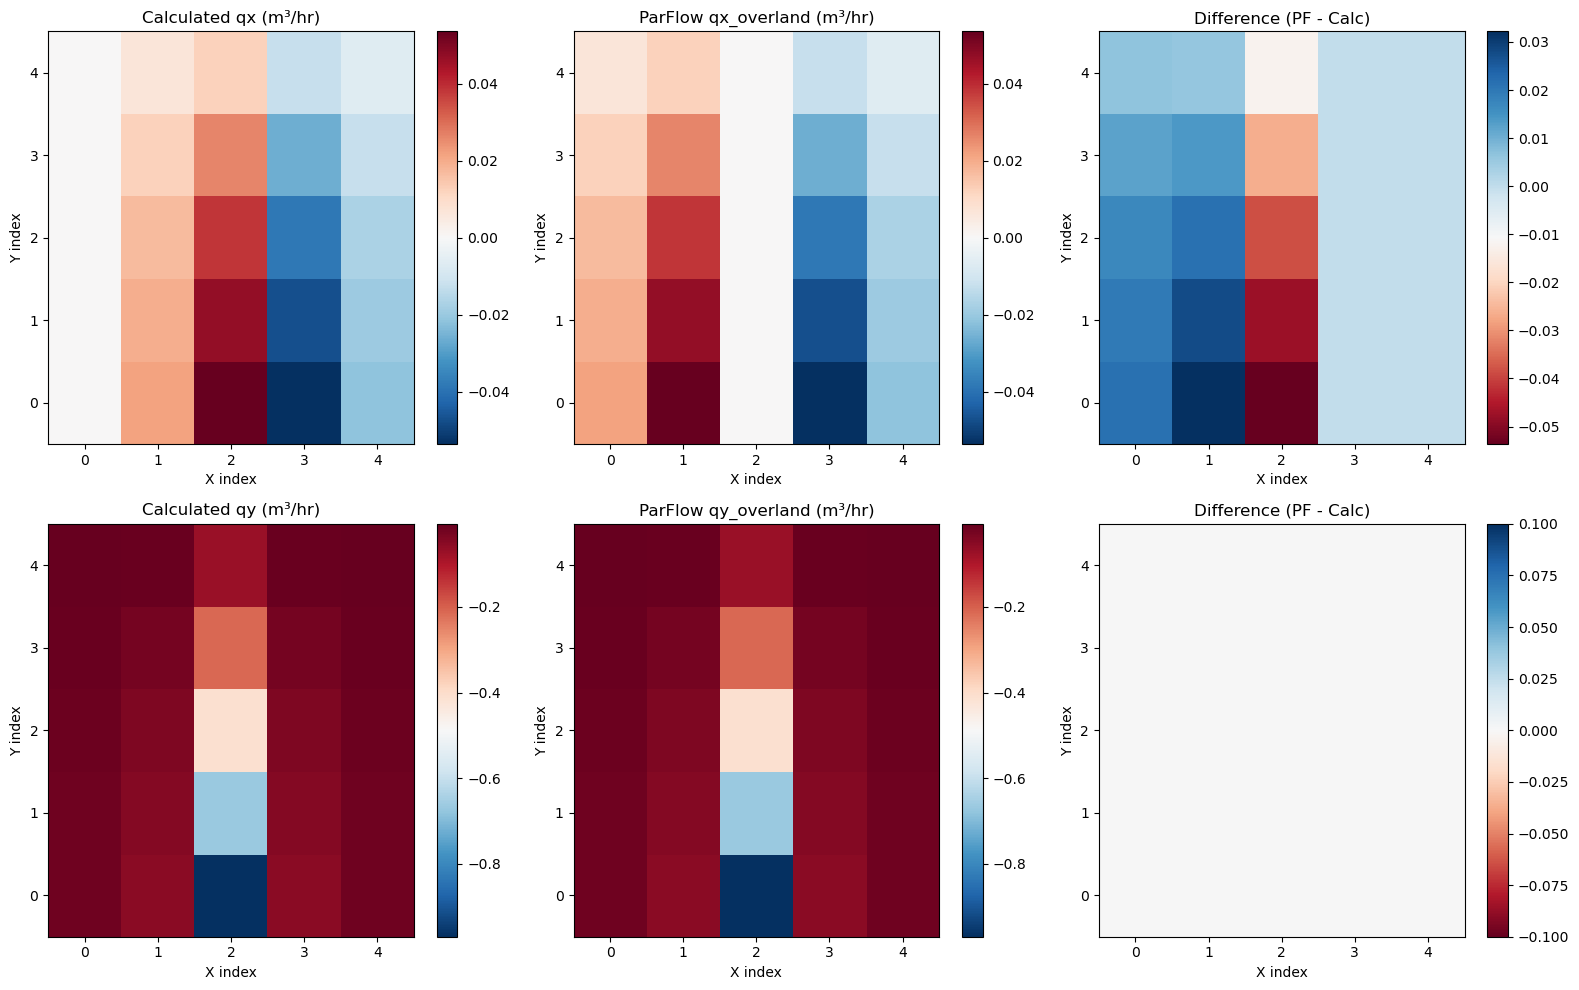

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: X-direction
vmin_x = min(qx_pf_2d.min(), qx_calc_2d.min())
vmax_x = max(qx_pf_2d.max(), qx_calc_2d.max())

im00 = axes[0,0].imshow(qx_calc_2d, origin='lower', cmap='RdBu_r', aspect='auto', vmin=vmin_x, vmax=vmax_x)
axes[0,0].set_title('Calculated qx (m³/hr)')
axes[0,0].set_xlabel('X index')
axes[0,0].set_ylabel('Y index')
plt.colorbar(im00, ax=axes[0,0])

im01 = axes[0,1].imshow(qx_pf_2d, origin='lower', cmap='RdBu_r', aspect='auto', vmin=vmin_x, vmax=vmax_x)
axes[0,1].set_title('ParFlow qx_overland (m³/hr)')
axes[0,1].set_xlabel('X index')
axes[0,1].set_ylabel('Y index')
plt.colorbar(im01, ax=axes[0,1])

im02 = axes[0,2].imshow(diff_x, origin='lower', cmap='RdBu', aspect='auto')
axes[0,2].set_title('Difference (PF - Calc)')
axes[0,2].set_xlabel('X index')
axes[0,2].set_ylabel('Y index')
plt.colorbar(im02, ax=axes[0,2])

# Row 2: Y-direction
vmin_y = min(qy_pf_2d.min(), qy_calc_2d.min())
vmax_y = max(qy_pf_2d.max(), qy_calc_2d.max())

im10 = axes[1,0].imshow(qy_calc_2d, origin='lower', cmap='RdBu_r', aspect='auto', vmin=vmin_y, vmax=vmax_y)
axes[1,0].set_title('Calculated qy (m³/hr)')
axes[1,0].set_xlabel('X index')
axes[1,0].set_ylabel('Y index')
plt.colorbar(im10, ax=axes[1,0])

im11 = axes[1,1].imshow(qy_pf_2d, origin='lower', cmap='RdBu_r', aspect='auto', vmin=vmin_y, vmax=vmax_y)
axes[1,1].set_title('ParFlow qy_overland (m³/hr)')
axes[1,1].set_xlabel('X index')
axes[1,1].set_ylabel('Y index')
plt.colorbar(im11, ax=axes[1,1])

im12 = axes[1,2].imshow(diff_y, origin='lower', cmap='RdBu', aspect='auto')
axes[1,2].set_title('Difference (PF - Calc)')
axes[1,2].set_xlabel('X index')
axes[1,2].set_ylabel('Y index')
plt.colorbar(im12, ax=axes[1,2])

plt.tight_layout()
plt.savefig('overland_flow_validation_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

## Scatter Plots: ParFlow vs Calculated

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# X-direction
axes[0].scatter(qx_calc_2d.flatten(), qx_pf_2d.flatten(), alpha=0.7, s=50)
axes[0].plot([qx_calc_2d.min(), qx_calc_2d.max()], [qx_calc_2d.min(), qx_calc_2d.max()], 
             'r--', linewidth=2, label='1:1 line')
axes[0].set_xlabel('Calculated qx (m³/hr)', fontsize=12)
axes[0].set_ylabel('ParFlow qx_overland (m³/hr)', fontsize=12)
axes[0].set_title('X-Direction Flux Comparison', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_aspect('equal', adjustable='box')

# Y-direction
axes[1].scatter(qy_calc_2d.flatten(), qy_pf_2d.flatten(), alpha=0.7, s=50)
axes[1].plot([qy_calc_2d.min(), qy_calc_2d.max()], [qy_calc_2d.min(), qy_calc_2d.max()], 
             'r--', linewidth=2, label='1:1 line')
axes[1].set_xlabel('Calculated qy (m³/hr)', fontsize=12)
axes[1].set_ylabel('ParFlow qy_overland (m³/hr)', fontsize=12)
axes[1].set_title('Y-Direction Flux Comparison', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('overland_flow_validation_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Examine Specific Cells with Large Differences

In [7]:
# Find cells with largest X-direction differences
abs_diff_x = np.abs(diff_x)
max_diff_indices = np.unravel_index(np.argsort(abs_diff_x.flatten())[-5:], abs_diff_x.shape)

print("Top 5 cells with largest X-direction differences:")
print("="*80)
for i in range(5):
    j_idx = max_diff_indices[0][-(i+1)]
    i_idx = max_diff_indices[1][-(i+1)]
    print(f"\nCell (j={j_idx}, i={i_idx}):")
    print(f"  ParFlow qx:    {qx_pf_2d[j_idx, i_idx]:.6e}")
    print(f"  Calculated qx: {qx_calc_2d[j_idx, i_idx]:.6e}")
    print(f"  Difference:    {diff_x[j_idx, i_idx]:.6e}")
    if abs(qx_calc_2d[j_idx, i_idx]) > 1e-10:
        print(f"  Relative err:  {abs(diff_x[j_idx, i_idx]/qx_calc_2d[j_idx, i_idx])*100:.2f}%")
    print(f"  Slope X:       {slope_x_2d[j_idx, i_idx]:.6e}")
    print(f"  Slope Y:       {slope_y_2d[j_idx, i_idx]:.6e}")
    if len(pressure.shape) == 3:
        print(f"  Pressure:      {pressure[-1, j_idx, i_idx]:.6f}")
    print(f"  Manning's:     {mannings_2d[j_idx, i_idx]:.6e}")

Top 5 cells with largest X-direction differences:

Cell (j=0, i=2):
  ParFlow qx:    0.000000e+00
  Calculated qx: 5.367896e-02
  Difference:    -5.367896e-02
  Relative err:  100.00%
  Slope X:       0.000000e+00
  Slope Y:       1.000000e-02
  Pressure:      0.000477
  Manning's:     3.000000e-06

Cell (j=1, i=2):
  ParFlow qx:    0.000000e+00
  Calculated qx: 4.735842e-02
  Difference:    -4.735842e-02
  Relative err:  100.00%
  Slope X:       0.000000e+00
  Slope Y:       1.000000e-02
  Pressure:      0.000381
  Manning's:     3.000000e-06

Cell (j=2, i=2):
  ParFlow qx:    0.000000e+00
  Calculated qx: 3.824485e-02
  Difference:    -3.824485e-02
  Relative err:  100.00%
  Slope X:       0.000000e+00
  Slope Y:       1.000000e-02
  Pressure:      0.000285
  Manning's:     3.000000e-06

Cell (j=0, i=1):
  ParFlow qx:    5.367896e-02
  Calculated qx: 2.146281e-02
  Difference:    3.221615e-02
  Relative err:  150.10%
  Slope X:       -1.000000e-02
  Slope Y:       1.000000e-02
  Pres

## Check Array Alignment

Let's examine the raw calculated arrays before subsetting to understand the structure better.

In [8]:
print("Array shape comparison:")
print(f"  ParFlow qx_pf_2d:  {qx_pf_2d.shape}")
print(f"  Raw qx_calc:       {qx_calc.shape}")
print(f"  Subset qx_calc_2d: {qx_calc_2d.shape}")
print(f"")
print(f"  ParFlow qy_pf_2d:  {qy_pf_2d.shape}")
print(f"  Raw qy_calc:       {qy_calc.shape}")
print(f"  Subset qy_calc_2d: {qy_calc_2d.shape}")

# Try different subsetting approaches for X
print("\n" + "="*80)
print("Testing different array subsetting for qx:")
print("="*80)

if len(qx_calc.shape) == 3:
    qx_test_first = qx_calc[0, :, 1:]  # Remove first column
    qx_test_last = qx_calc[0, :, :-1]  # Remove last column
else:
    qx_test_first = qx_calc[:, 1:]
    qx_test_last = qx_calc[:, :-1]

diff_first = qx_pf_2d - qx_test_first
diff_last = qx_pf_2d - qx_test_last

print(f"\nRemoving first column (qx_calc[:, 1:]):")
print(f"  Shape: {qx_test_first.shape}")
print(f"  Diff stats: min={diff_first.min():.6e}, max={diff_first.max():.6e}, mean={diff_first.mean():.6e}, std={diff_first.std():.6e}")

print(f"\nRemoving last column (qx_calc[:, :-1]):")
print(f"  Shape: {qx_test_last.shape}")
print(f"  Diff stats: min={diff_last.min():.6e}, max={diff_last.max():.6e}, mean={diff_last.mean():.6e}, std={diff_last.std():.6e}")

print(f"\nCurrent approach (remove last):")
print(f"  Shape: {qx_calc_2d.shape}")
print(f"  Diff stats: min={diff_x.min():.6e}, max={diff_x.max():.6e}, mean={diff_x.mean():.6e}, std={diff_x.std():.6e}")

Array shape comparison:
  ParFlow qx_pf_2d:  (5, 5)
  Raw qx_calc:       (5, 6)
  Subset qx_calc_2d: (5, 5)

  ParFlow qy_pf_2d:  (5, 5)
  Raw qy_calc:       (6, 5)
  Subset qy_calc_2d: (5, 5)

Testing different array subsetting for qx:

Removing first column (qx_calc[:, 1:]):
  Shape: (5, 5)
  Diff stats: min=-3.221615e-02, max=5.367896e-02, mean=-2.081668e-19, std=2.120882e-02

Removing last column (qx_calc[:, :-1]):
  Shape: (5, 5)
  Diff stats: min=-5.367896e-02, max=3.221615e-02, mean=-1.387779e-19, std=2.120882e-02

Current approach (remove last):
  Shape: (5, 5)
  Diff stats: min=-5.367896e-02, max=3.221615e-02, mean=-1.387779e-19, std=2.120882e-02


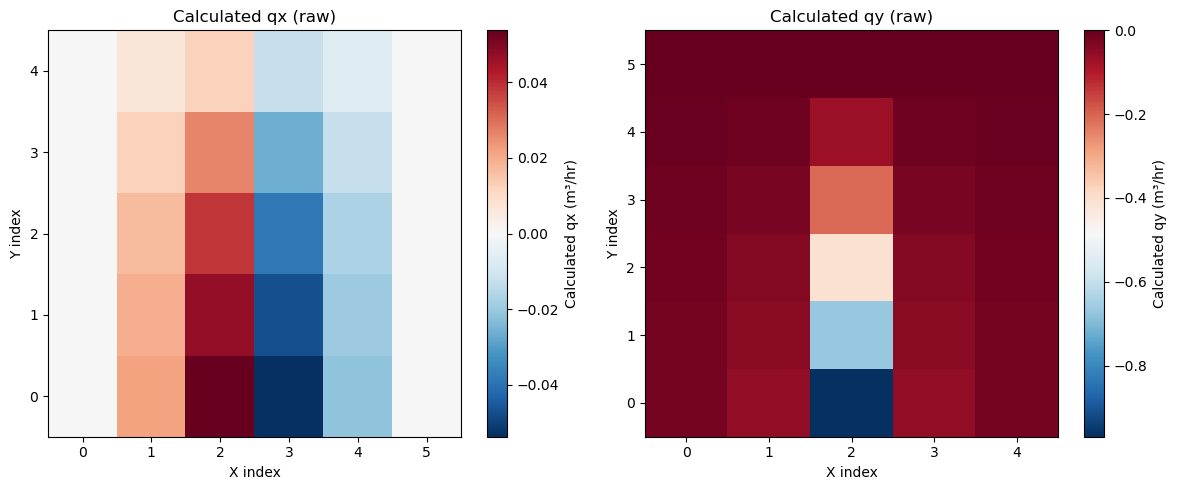

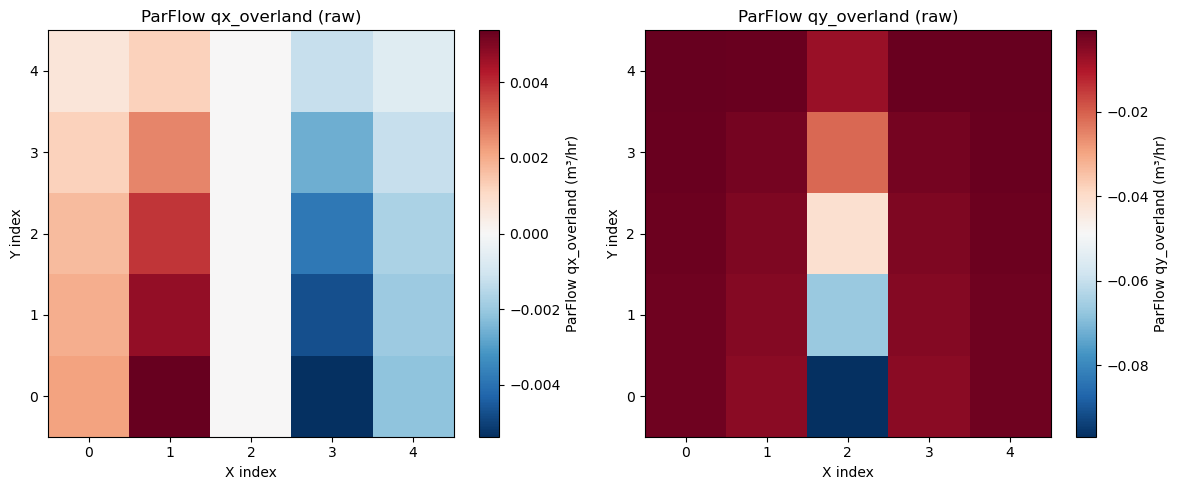

In [ ]:
#plot raw qx and qy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(qx_calc, origin='lower', cmap='RdBu_r', aspect='auto')
plt.colorbar(label='Calculated qx (m³/hr)')
plt.title('Calculated qx (raw)')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.subplot(1, 2, 2)
plt.imshow(qy_calc, origin='lower', cmap='RdBu_r', aspect='auto')
plt.colorbar(label='Calculated qy (m³/hr)')
plt.title('Calculated qy (raw)')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.tight_layout()
plt.show()
#save figure
plt.savefig('calculated_overland_fluxes_raw.png', dpi=150, bbox_inches='tight')

#now plot native parflow outputs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(qx_pf[0,:,:], origin='lower', cmap='RdBu_r', aspect='auto')
plt.colorbar(label='ParFlow qx_overland (m³/hr)')
plt.title('ParFlow qx_overland (raw)')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.subplot(1, 2, 2)
plt.imshow(qy_pf[0,:,:], origin='lower', cmap='RdBu_r', aspect='auto')
plt.colorbar(label='ParFlow qy_overland (m³/hr)')
plt.title('ParFlow qy_overland (raw)')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.tight_layout()
plt.show()
#save figure
plt.savefig('parflow_overland_fluxes_raw.png', dpi=150, bbox_inches='tight')